In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
data_path = "../data/genres_original/"

In [3]:
Music_data = []
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            entry = {
                "path": os.path.join(root, file),
                "label": file.split(".")[0],
            }
        else:
            print(file, root)
        Music_data.append(entry)


Music_data = pd.DataFrame(Music_data)
Music_data["path"] = Music_data["path"].str.replace("\\", "/", regex=False)
Music_data.to_csv("../data/Music_data.csv", sep="\t", encoding="utf-8", index=False)

In [4]:
Music_data.head(-10)

,path,label
0,../data/genres_original/blues/blues.00000.wav,blues
1,../data/genres_original/blues/blues.00001.wav,blues
2,../data/genres_original/blues/blues.00002.wav,blues
3,../data/genres_original/blues/blues.00003.wav,blues
4,../data/genres_original/blues/blues.00004.wav,blues
...,...,...
985,../data/genres_original/rock/rock.00085.wav,rock
986,../data/genres_original/rock/rock.00086.wav,rock
987,../data/genres_original/rock/rock.00087.wav,rock
988,../data/genres_original/rock/rock.00088.wav,rock


In [5]:
# Data = Music_data.sample(n=50, random_state=101)
Data = Music_data


Data = Data.reset_index(drop=True)

In [6]:
Data.head(-1)

,path,label
0,../data/genres_original/blues/blues.00000.wav,blues
1,../data/genres_original/blues/blues.00001.wav,blues
2,../data/genres_original/blues/blues.00002.wav,blues
3,../data/genres_original/blues/blues.00003.wav,blues
4,../data/genres_original/blues/blues.00004.wav,blues
...,...,...
994,../data/genres_original/rock/rock.00094.wav,rock
995,../data/genres_original/rock/rock.00095.wav,rock
996,../data/genres_original/rock/rock.00096.wav,rock
997,../data/genres_original/rock/rock.00097.wav,rock


In [7]:
print(f"Genre:{Data["label"].unique()}")
Data.groupby("label").count()[["path"]]

Genre:['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


,path
label,
blues,100
classical,100
country,100
disco,100
hiphop,100
jazz,100
metal,100
pop,100
reggae,100


In [8]:
unique_labels = Data["label"].unique()
print(f"{unique_labels}")

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [9]:
data = {"label": unique_labels}

label_2_idx = {label: idx for idx, label in enumerate(unique_labels)}

print(label_2_idx)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [10]:
class Preprocessing:
    def __init__(self, segment_length_sec=1, overlap=0.5, sr=44000):
        self.segment_length_sec = segment_length_sec
        self.sr = sr
        self.hop_length_sec = segment_length_sec * (1 - overlap)
        self.hop_length_samples = int(self.hop_length_sec * self.sr)

    def normalization_audio(self, file_path):
        try:
            audio, _ = librosa.load(file_path, sr=self.sr)
            audio = audio / np.max(np.abs(audio))
            return audio
        except Exception as e:
            print(f"Could not load file {file_path}: {e}")

    def segment_audio(self, audio):
        segment_length_samples = int(self.segment_length_sec * self.sr)

        segments = [
            audio[i : i + segment_length_samples]
            for i in range(
                0, len(audio) - segment_length_samples + 1, self.hop_length_samples
            )
        ]
        return np.array(segments)

    def mfcc_extract(self, audio):
        mfcc = librosa.feature.mfcc(y=audio, sr=self.sr, n_mfcc=13)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        return mfcc, delta_mfcc, delta2_mfcc

    def chroma_extract(self, audio):
        chroma = librosa.feature.chroma_stft(y=audio, sr=self.sr)
        return chroma

    def spectral_extract(self, audio):
        centroid = librosa.feature.spectral_centroid(
            y=audio,
            sr=self.sr,
        )
        rolloff = librosa.feature.spectral_rolloff(
            y=audio,
            sr=self.sr,
            roll_percent=0.85,
        )
        contrast = librosa.feature.spectral_contrast(
            y=audio,
            sr=self.sr,
        )
        return centroid, rolloff, contrast

    def temporal_extract(self, audio):
        zcr = librosa.feature.zero_crossing_rate(y=audio)
        rmse = librosa.feature.rms(y=audio)
        return zcr, rmse

    def stack_features(self, feature_list):

        max_rows = max(feature.shape[0] for feature in feature_list)
        num_frames = feature_list[0].shape[1]

        features = []
        for feature in feature_list:
            rows, frames = feature.shape

            if rows < max_rows:
                padding = ((0, max_rows - rows), (0, 0))
                padded_features = np.pad(feature, padding, mode="constant")
            else:
                padded_features = feature

            features.append(padded_features)

        feature_vector = np.hstack(features).flatten()
        return feature_vector

    def feature_extraction(self, file_path):

        features = []
        audio = self.normalization_audio(file_path)
        segmented_audio = self.segment_audio(audio)

        for segment in segmented_audio:
            # Extract features for each segment
            mfcc, delta, delta_2 = self.mfcc_extract(segment)
            chroma = self.chroma_extract(segment)
            centroid, rolloff, contrast = self.spectral_extract(segment)
            zc, rmse = self.temporal_extract(segment)

            # Store the extracted features for the current segment
            stacked_features = self.stack_features(
                [mfcc, delta, delta_2, chroma, centroid, rolloff, contrast, zc, rmse]
            )
            # stacked_features = self.stack_features([mfcc])
            features.append(stacked_features)

        feature_matrix = np.array(features)

        scaler = StandardScaler()
        stacked_features = scaler.fit_transform(feature_matrix.T).T
        # print(stacked_features.shape)
        return stacked_features

In [ ]:
from IPython.display import Audio
import random as rd
import matplotlib.pyplot as plt

In [12]:
idx = rd.randint(0, Data.shape[0])
processor = Preprocessing(segment_length_sec=5, overlap=0.5, sr=16000)

sample_audio = Data["path"][idx]
label = Data["label"][idx]


features_vector = processor.feature_extraction(sample_audio)

print(f"Genre : {label}")
print(f"Features shape: {features_vector.shape}")
Audio(sample_audio)

Genre : pop
Features shape: (11, 18369)


In [13]:
import numpy as np
from tqdm import tqdm


from sklearn.model_selection import train_test_split

In [14]:
data_save_path = "../data/csv"
train_df, test_df = train_test_split(
    Data, test_size=0.2, random_state=100, stratify=Data["label"]
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [15]:
print(f"Train : {train_df.shape} | Test : {test_df.shape}")

Train : (800, 2) | Test : (200, 2)


In [16]:
# Saving to CSV for easying calling
train_df.to_csv(f"{data_save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{data_save_path}/test.csv", sep="\t", encoding="utf-8", index=False)

In [17]:
def one_hot_encoding_labels(label, label_to_idx, unique_labels):
    num_classes = len(unique_labels)
    one_hot = np.eye(num_classes)[label_to_idx[label]]
    return one_hot

In [18]:
def dataloader(batch, label_2_idx, unique_labels, batch_size=32):
    dataset = []
    num_samples = len(batch["path"])
    # Process data in batches
    for i in tqdm(
        range(0, num_samples, batch_size),
        total=(num_samples + batch_size - 1) // batch_size,
        desc="Loading Data",
    ):
        batch_paths = batch["path"][i : i + batch_size]
        batch_labels = batch["label"][i : i + batch_size]

        # Process each file in the current batch
        batch_entries = []
        for file_path, label in zip(batch_paths, batch_labels):
            features = processor.feature_extraction(file_path)
            label_one_hot = one_hot_encoding_labels(label, label_2_idx, unique_labels)
            batch_entries.append({"features": features, "labels": label_one_hot})

        dataset.extend(batch_entries)  # Add processed batch to the dataset
    return dataset

In [19]:
Train = dataloader(train_df, label_2_idx, unique_labels, batch_size=32)
Validation = dataloader(test_df, label_2_idx, unique_labels, batch_size=32)

Loading Data: 100%|██████████| 7/7 [01:45<00:00, 15.05s/it]


In [20]:
num_train_data = len(Train)
num_valid_data = len(Validation)

In [21]:
def reshape_dims(Data, n_samples, feature_shape):

    Dataset = []
    features = np.concatenate([d["features"] for d in Data])
    labels = np.concatenate([d["labels"] for d in Data])

    # Normalize features if needed
    features = (features - np.min(features)) / (np.max(features) - np.min(features))
    features = np.resize(
        features, (n_samples * feature_shape.shape[0] * feature_shape.shape[1])
    )
    features = features.reshape(
        n_samples, feature_shape.shape[0], feature_shape.shape[1]
    )
    labels = labels.reshape(n_samples, -1)
    Dataset = [features, labels]
    return Dataset

In [22]:
train_features = reshape_dims(Train, num_train_data, features_vector)
valid_features = reshape_dims(Validation, num_valid_data, features_vector)

In [23]:
train_features[0].shape

(800, 11, 18369)

In [24]:
valid_features[0].shape

(200, 11, 18369)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchgan.losses import WassersteinDiscriminatorLoss, WassersteinGeneratorLoss

In [26]:
NOISE_DIM = 100
LABEL_DIM = len(unique_labels)
OUTPUT_SHAPE = features_vector.shape[0:]
EPOCHS = 100
BATCH_SIZE = 12

In [27]:
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dims, output_shape):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.label_dims = label_dims
        self.output_shape = output_shape
        flattened_output_dim = torch.prod(torch.tensor(output_shape)).item()

        self.fc1 = nn.Linear(noise_dim + label_dims, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, flattened_output_dim)

    def forward(self, noise, labels):
        # Concatenate noise and label inputs
        x = torch.cat((noise, labels), dim=1)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = torch.tanh(self.fc3(x))
        # Reshape output to desired shape
        x = x.view(x.size(0), *self.output_shape)
        return x

In [28]:
class Discriminator(nn.Module):
    def __init__(self, feature_shape, label_dim):
        super(Discriminator, self).__init__()
        self.feature_shape = feature_shape
        self.label_dim = label_dim
        flattened_feature_dim = torch.prod(torch.tensor(feature_shape)).item()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flattened_feature_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256 + label_dim, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, features, labels):
        # Flatten the input feature tensor
        x = self.flatten(features)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        # Concatenate the processed features with the label input
        x = torch.cat((x, labels), dim=1)
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = torch.sigmoid(self.fc4(x))  # Real or fake classification
        return x

In [29]:
generator = Generator(NOISE_DIM, LABEL_DIM, OUTPUT_SHAPE)
discriminator = Discriminator(OUTPUT_SHAPE, LABEL_DIM)

# Optimizers
initial_lr = 1e-3
decay_factor = 0.5
step_size = 10
beta1 = 0.5

optimizer_g = optim.Adam(generator.parameters(), lr=initial_lr, betas=(beta1, 0.999))
scheduler_g = torch.optim.lr_scheduler.StepLR(
    optimizer_g, step_size=step_size, gamma=decay_factor
)
optimizer_d = optim.Adam(
    discriminator.parameters(), lr=initial_lr, betas=(beta1, 0.999)
)
scheduler_d = torch.optim.lr_scheduler.StepLR(
    optimizer_d, step_size=step_size, gamma=decay_factor
)

# Loss function
criterion = nn.BCELoss()

In [30]:
def print_gradients(model, prefix=""):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"{prefix} {name} - max grad: {param.grad.max():.4f}, min grad: {param.grad.min():.4f}")

In [31]:
def train_gan(
    generator,
    discriminator,
    optimizer_g,
    scheduler_g,
    optimizer_d,
    scheduler_d,
    data,
    epochs,
    batch_size,
    label_dim,
    noise_dim,
    device="cpu",
):
    d_losses = []
    g_losses = []
    generator.to(device)
    discriminator.to(device)
    features = torch.tensor(data[0], dtype=torch.float32).to(device)
    labels = torch.tensor(data[1], dtype=torch.float32).to(device)

    for epoch in range(epochs):
        # Select a random batch of real features and labels
        if batch_size > features.size(0):
            raise NameError(
                f"batch_Size : {batch_size} cannot be greater than features size : {features.size(0)}"
            )
        elif batch_size == features.size(0):
            real_features = features
            real_labels = labels
        else:
            idx = np.random.randint(0, features.size(0), batch_size)
            real_features = features[idx]
            real_labels = labels[idx]

        # Labels for real and fake data validators
        real_validity = torch.ones((batch_size, 1), device=device)
        fake_validity = torch.zeros((batch_size, 1), device=device)

        # Creating a Noise Vector
        noise = torch.randn(batch_size, noise_dim, device=device)

        # Category Indices for Generating One Hot encoding for Labels
        class_indices = torch.randint(0, label_dim, (batch_size,), device=device)

        # Fake One Hot Encoded Labels & Fake Features Generation
        fake_labels = torch.nn.functional.one_hot(
            class_indices, num_classes=label_dim
        ).float()
        generated_features = generator(noise, fake_labels)

        # Training Discriminator
        discriminator.train()
        scheduler_d.step()
        optimizer_d.zero_grad()

        # Using Real features and Calculating Real Loss
        real_loss = criterion(discriminator(real_features, real_labels), real_validity)

        # Using Fake features  and Calculating Fake Loss
        fake_loss = criterion(
            discriminator(generated_features, fake_labels), fake_validity
        )

        # Discriminator Loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_d.step()

        # Training Generator
        generator.train()
        scheduler_g.step()
        optimizer_g.zero_grad()

        # Generate noise and fake labels
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_labels = torch.nn.functional.one_hot(
            class_indices, num_classes=label_dim
        ).float()

        # The generator tries to fool the discriminator into believing the fake features are real
        # Generator Loss
        g_loss = criterion(
            discriminator(generator(noise, fake_labels), fake_labels), real_validity
        )

        g_loss.backward()

        optimizer_g.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        # Print progress
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(
                f"Epoch {epoch}/{epochs} [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )
            
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Losses over Epochs')
    plt.show()

    # print("Discriminator Gradients:")
    # print_gradients(discriminator, prefix="D")
    # print("Generator Gradients:")
    # print_gradients(generator, prefix="G")

In [32]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

d:\Personal Projects\Music\Music Synthesis Using GANs\venv\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 0/100 [D loss: 0.7421] [G loss: 0.8074]
Epoch 10/100 [D loss: 0.7125] [G loss: 0.7142]
Epoch 20/100 [D loss: 0.7046] [G loss: 0.7029]
Epoch 30/100 [D loss: 0.6994] [G loss: 0.6983]
Epoch 40/100 [D loss: 0.7061] [G loss: 0.6997]
Epoch 50/100 [D loss: 0.7025] [G loss: 0.6987]
Epoch 60/100 [D loss: 0.6988] [G loss: 0.6992]
Epoch 70/100 [D loss: 0.6965] [G loss: 0.7047]
Epoch 80/100 [D loss: 0.7012] [G loss: 0.7069]
Epoch 90/100 [D loss: 0.7010] [G loss: 0.7017]
Epoch 99/100 [D loss: 0.6990] [G loss: 0.7067]


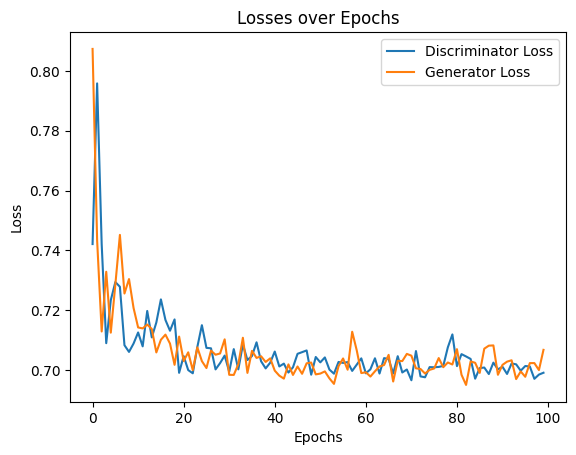

In [33]:
train_gan(
    generator=generator,
    discriminator=discriminator,
    optimizer_g=optimizer_g,
    scheduler_g=scheduler_g,
    optimizer_d=optimizer_d,
    scheduler_d=scheduler_d,
    data=train_features,
    epochs=EPOCHS,  # Explicitly pass epochs as a keyword argument
    batch_size=BATCH_SIZE,  # Explicitly pass batch_size as a keyword argument
    label_dim=LABEL_DIM,
    noise_dim=NOISE_DIM,
    device=device,  # Keep device as a keyword argument
)

In [41]:
def test_generator(generator, num_samples, noise_dim, label_dim, device="cpu"):
    noise = torch.randn(num_samples, noise_dim, device=device)
    class_indices = torch.randint(0, label_dim, (num_samples,), device=device)
    labels = torch.nn.functional.one_hot(class_indices, num_classes=label_dim).float()

    generator.eval()
    with torch.no_grad():
        generated_features = generator(noise, labels)

    return generated_features, labels

In [42]:
generated_features, labels = test_generator(
    generator, num_samples=10, noise_dim=NOISE_DIM, label_dim=LABEL_DIM, device=device
)
print(f"Features: {generated_features.shape} | Label : {labels[0]}")

Features: torch.Size([10, 11, 18369]) | Label : tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


In [43]:
# Visualize generated features if they are images
if (
    generated_features.shape[1] == 3
):  # Assuming RGB image shape (batch, channels, height, width)
    import matplotlib.pyplot as plt

    for i in range(generated_features.size(0)):
        plt.imshow(
            generated_features[i].permute(1, 2, 0).cpu().numpy()
        )  # Convert to HWC format
        plt.show()

In [56]:
def test_discriminator(
    discriminator,
    features,
    labels,
    generator,
    num_samples,
    noise_dim,
    label_dim,
    device="cpu",
):
    # assert isinstance(data, (list, tuple)) and len(data) == 2, "data should be a tuple (features, labels)"
    real_features = torch.tensor(features, dtype=torch.float32).to(device)
    real_labels = torch.tensor(labels, dtype=torch.float32).to(device)

    noise = torch.randn(num_samples, noise_dim, device=device)
    fake_labels = torch.randint(0, 2, (num_samples, label_dim), device=device).float()

    discriminator.eval()
    with torch.no_grad():
        # Generate fake features
        generated_features = generator(noise, fake_labels)

        # Ensure generated features have the correct shape
        assert (
            generated_features.shape[1:] == real_features.shape[1:]
        ), f"Generated features shape {generated_features.shape} does not match real features {real_features.shape}"

        # Discriminator predictions
        real_preds = torch.sigmoid(discriminator(real_features, real_labels))
        fake_preds = torch.sigmoid(discriminator(generated_features, fake_labels))

    return np.array(real_preds), np.array(fake_preds)

In [59]:
real_preds, fake_preds = test_discriminator(
    discriminator=discriminator,
    features=valid_features[0][:5],
    labels=valid_features[1][:5],
    generator=generator,
    num_samples=5,
    noise_dim=NOISE_DIM,
    label_dim=LABEL_DIM,
    device=device,
)

print(f"Real Predictions: {real_preds.T}")
print(f"Fake Predictions: {fake_preds.T}")

Real Predictions: [[0.628928   0.62900645 0.6277563  0.63070697 0.63100857]]
Fake Predictions: [[0.6316878  0.6238592  0.6421097  0.60294086 0.6182972 ]]


In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [47]:
def compute_metrics(real_preds, fake_preds):
    real_labels = [1] * len(real_preds)
    fake_labels = [0] * len(fake_preds)
    all_preds = (real_preds > 0.5).astype(int).tolist() + (fake_preds > 0.5).astype(
        int
    ).tolist()
    all_true_labels = real_labels + fake_labels

    accuracy = accuracy_score(all_true_labels, all_preds)
    precision = precision_score(all_true_labels, all_preds)
    recall = recall_score(all_true_labels, all_preds)
    f1 = f1_score(all_true_labels, all_preds)

    return {
        "accuracy": accuracy,
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
    }


metrics = compute_metrics(real_preds, fake_preds)
print("Metrics:", metrics)

Metrics: {'accuracy': 0.5, 'precision': 0.5, 'recall': 1.0, 'f1': 0.6666666666666666}
